# 5.0 Strategy Rethink

The short strategy only works on illiquid stocks where execution is impractical.
Let's explore alternatives:

1. **Long side** - Does the model predict winners in tradeable stocks?
2. **Longer holding periods** - Can we amortize costs over multiple days?
3. **Liquid universe only** - Is there any signal in >$50M stocks?
4. **Combined long/short** - Does L/S work better than short-only?

In [1]:
import sys
sys.path.insert(0, '.')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
from scipy import stats

from trading.model import ModelInference

plt.style.use('seaborn-v0_8-whitegrid')
plt.rcParams['figure.figsize'] = (14, 5)

In [2]:
# Load model and data
MODEL_PATH = Path('data/model_robust_optimized.pt')
model = ModelInference(MODEL_PATH)

df = pd.read_parquet('data/ml_dataset.pqt')
df['feature_date'] = pd.to_datetime(df['feature_date'])
df['simple_return'] = np.exp(df['target_return']) - 1

# Load prices for multi-day returns and liquidity
prices_df = pd.read_parquet('data/prices.pqt')
prices_df['date'] = pd.to_datetime(prices_df['date'])
prices_df['dollar_volume'] = prices_df['volume'] * prices_df['close']

TEST_START = '2024-10-22'
test_df = df[df['feature_date'] >= TEST_START].copy()

# Filter to news-only
emb_cols = [c for c in test_df.columns if c.startswith('emb_')]
has_news = (test_df[emb_cols].abs().sum(axis=1) > 0)
test_news = test_df[has_news].copy()

# Score all stocks
test_news['score'] = model.score(test_news)

print(f"Test period: {test_news['feature_date'].min().date()} to {test_news['feature_date'].max().date()}")
print(f"Rows: {len(test_news):,}")
print(f"Unique dates: {test_news['feature_date'].nunique()}")

Test period: 2024-10-22 to 2025-12-18
Rows: 128,502
Unique dates: 238


In [3]:
# Add liquidity info
test_prices = prices_df[prices_df['date'] >= TEST_START].copy()
symbol_liquidity = test_prices.groupby('symbol')['dollar_volume'].mean().reset_index()
symbol_liquidity.columns = ['symbol', 'avg_dollar_volume']

test_news = test_news.merge(symbol_liquidity, on='symbol', how='left')
print(f"Added liquidity data for {test_news['avg_dollar_volume'].notna().sum():,} rows")

Added liquidity data for 128,502 rows


## 1. Long Side Analysis

Does buying top-K stocks work? Less friction than shorting.

In [4]:
# Build portfolios for each day
K = 5
results = []

for date, group in test_news.groupby('feature_date'):
    if len(group) < 20:
        continue
    
    # Top-K (longs) and Bottom-K (shorts)
    top_k = group.nlargest(K, 'score')
    bottom_k = group.nsmallest(K, 'score')
    
    results.append({
        'date': date,
        'long_return': top_k['simple_return'].mean(),
        'short_return': -bottom_k['simple_return'].mean(),  # Flip sign for short profit
        'market_return': group['simple_return'].mean(),
        'long_avg_dv': top_k['avg_dollar_volume'].mean(),
        'short_avg_dv': bottom_k['avg_dollar_volume'].mean(),
    })

results_df = pd.DataFrame(results)
results_df['ls_return'] = (results_df['long_return'] + results_df['short_return']) / 2
results_df['long_excess'] = results_df['long_return'] - results_df['market_return']
results_df['short_excess'] = results_df['short_return'] + results_df['market_return']  # Short profits when market falls

print(f"Trading days: {len(results_df)}")

Trading days: 238


In [5]:
# Compare strategies
print("STRATEGY COMPARISON (All Stocks)")
print("=" * 70)

strategies = {
    'Long Top-5': 'long_return',
    'Short Bottom-5': 'short_return',
    'Long/Short': 'ls_return',
    'Long Excess (vs mkt)': 'long_excess',
}

for name, col in strategies.items():
    daily_mean = results_df[col].mean()
    daily_std = results_df[col].std()
    sharpe = daily_mean / daily_std * np.sqrt(252) if daily_std > 0 else 0
    ann_return = daily_mean * 252 * 100
    win_rate = (results_df[col] > 0).mean() * 100
    
    print(f"\n{name}:")
    print(f"  Daily: {daily_mean*100:.3f}% +/- {daily_std*100:.3f}%")
    print(f"  Annualized: {ann_return:.1f}%")
    print(f"  Sharpe: {sharpe:.2f}")
    print(f"  Win rate: {win_rate:.1f}%")

STRATEGY COMPARISON (All Stocks)

Long Top-5:
  Daily: 0.007% +/- 1.489%
  Annualized: 1.7%
  Sharpe: 0.07
  Win rate: 47.5%

Short Bottom-5:
  Daily: 0.917% +/- 11.045%
  Annualized: 231.0%
  Sharpe: 1.32
  Win rate: 62.6%

Long/Short:
  Daily: 0.462% +/- 5.439%
  Annualized: 116.3%
  Sharpe: 1.35
  Win rate: 63.0%

Long Excess (vs mkt):
  Daily: 0.017% +/- 1.095%
  Annualized: 4.4%
  Sharpe: 0.25
  Win rate: 50.0%


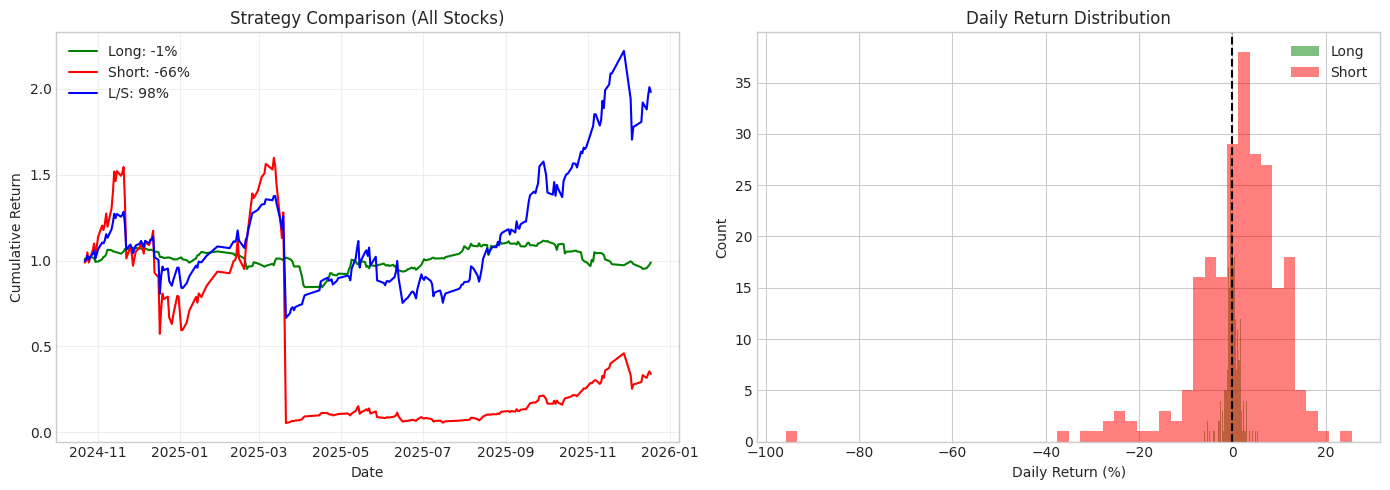

In [6]:
# Cumulative returns
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
for name, col, color in [('Long', 'long_return', 'green'), 
                          ('Short', 'short_return', 'red'),
                          ('L/S', 'ls_return', 'blue')]:
    cum_ret = (1 + results_df[col]).cumprod()
    ax.plot(results_df['date'], cum_ret, label=f'{name}: {(cum_ret.iloc[-1]-1)*100:.0f}%', color=color)

ax.set_xlabel('Date')
ax.set_ylabel('Cumulative Return')
ax.set_title('Strategy Comparison (All Stocks)')
ax.legend()
ax.grid(True, alpha=0.3)

# Daily returns distribution
ax = axes[1]
ax.hist(results_df['long_return'] * 100, bins=50, alpha=0.5, label='Long', color='green')
ax.hist(results_df['short_return'] * 100, bins=50, alpha=0.5, label='Short', color='red')
ax.axvline(0, color='black', linestyle='--')
ax.set_xlabel('Daily Return (%)')
ax.set_ylabel('Count')
ax.set_title('Daily Return Distribution')
ax.legend()

plt.tight_layout()
plt.show()

In [7]:
# Liquidity of selected stocks
print("\nLIQUIDITY OF SELECTED STOCKS")
print("=" * 50)
print(f"Long portfolio avg daily $ volume: ${results_df['long_avg_dv'].mean()/1e6:.1f}M")
print(f"Short portfolio avg daily $ volume: ${results_df['short_avg_dv'].mean()/1e6:.1f}M")


LIQUIDITY OF SELECTED STOCKS
Long portfolio avg daily $ volume: $285.0M
Short portfolio avg daily $ volume: $138.8M


## 2. Liquid Universe Only

Filter to stocks with >$50M daily volume and re-test.

In [8]:
# Test different liquidity thresholds
thresholds = [10e6, 25e6, 50e6, 100e6, 200e6]
threshold_results = []

for thresh in thresholds:
    liquid = test_news[test_news['avg_dollar_volume'] >= thresh].copy()
    
    if len(liquid) < 100:
        continue
    
    daily_results = []
    for date, group in liquid.groupby('feature_date'):
        if len(group) < 10:
            continue
        
        top_k = group.nlargest(K, 'score')
        bottom_k = group.nsmallest(K, 'score')
        
        daily_results.append({
            'date': date,
            'long_return': top_k['simple_return'].mean(),
            'short_return': -bottom_k['simple_return'].mean(),
            'n_stocks': len(group),
        })
    
    if len(daily_results) < 50:
        continue
        
    dr = pd.DataFrame(daily_results)
    dr['ls_return'] = (dr['long_return'] + dr['short_return']) / 2
    
    threshold_results.append({
        'threshold': thresh / 1e6,
        'n_days': len(dr),
        'avg_stocks_per_day': dr['n_stocks'].mean(),
        'long_daily': dr['long_return'].mean(),
        'long_sharpe': dr['long_return'].mean() / dr['long_return'].std() * np.sqrt(252),
        'short_daily': dr['short_return'].mean(),
        'short_sharpe': dr['short_return'].mean() / dr['short_return'].std() * np.sqrt(252),
        'ls_daily': dr['ls_return'].mean(),
        'ls_sharpe': dr['ls_return'].mean() / dr['ls_return'].std() * np.sqrt(252),
    })

thresh_df = pd.DataFrame(threshold_results)
print("PERFORMANCE BY LIQUIDITY THRESHOLD")
print("=" * 90)
print(thresh_df.round(4).to_string(index=False))

PERFORMANCE BY LIQUIDITY THRESHOLD
 threshold  n_days  avg_stocks_per_day  long_daily  long_sharpe  short_daily  short_sharpe  ls_daily  ls_sharpe
      10.0     238            529.4454      0.0003       0.3544      -0.0016       -0.2482   -0.0006    -0.2002
      25.0     238            465.2143      0.0000       0.0152      -0.0102       -1.3826   -0.0051    -1.3921
      50.0     238            391.9832     -0.0003      -0.3586      -0.0067       -1.2551   -0.0035    -1.3527
     100.0     238            305.7521     -0.0003      -0.3289      -0.0085       -1.5917   -0.0044    -1.6983
     200.0     238            219.5042     -0.0002      -0.2104      -0.0067       -1.9682   -0.0035    -2.1401


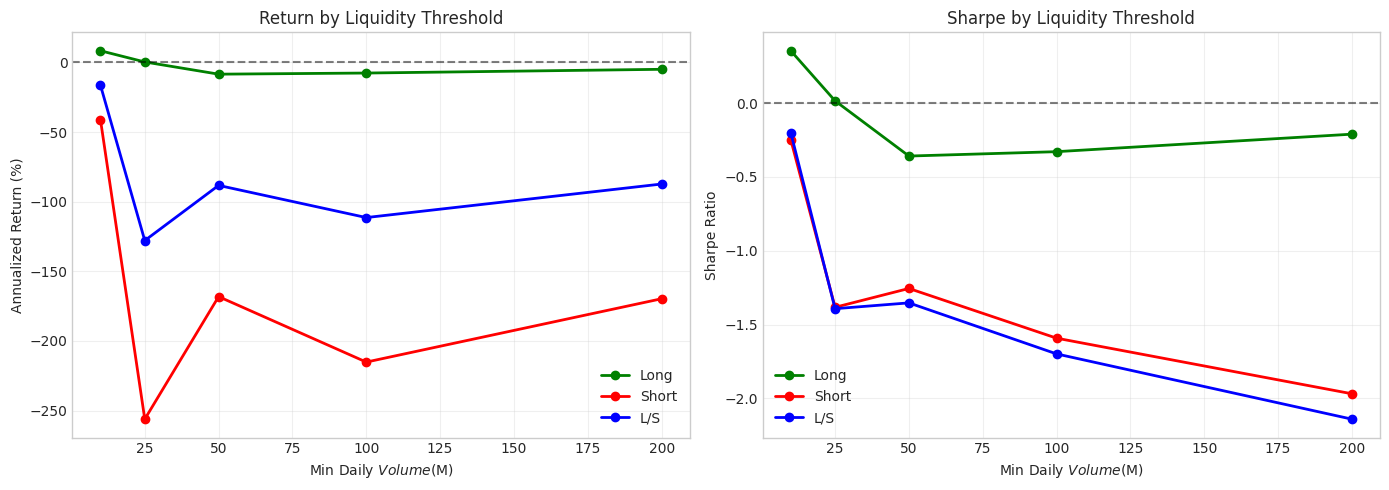

In [9]:
# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

ax = axes[0]
x = thresh_df['threshold']
ax.plot(x, thresh_df['long_daily'] * 252 * 100, 'g-o', label='Long', linewidth=2)
ax.plot(x, thresh_df['short_daily'] * 252 * 100, 'r-o', label='Short', linewidth=2)
ax.plot(x, thresh_df['ls_daily'] * 252 * 100, 'b-o', label='L/S', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Min Daily $ Volume ($M)')
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Return by Liquidity Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

ax = axes[1]
ax.plot(x, thresh_df['long_sharpe'], 'g-o', label='Long', linewidth=2)
ax.plot(x, thresh_df['short_sharpe'], 'r-o', label='Short', linewidth=2)
ax.plot(x, thresh_df['ls_sharpe'], 'b-o', label='L/S', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Min Daily $ Volume ($M)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe by Liquidity Threshold')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [10]:
# Deep dive on $50M+ threshold
LIQUID_THRESH = 50e6
liquid_stocks = test_news[test_news['avg_dollar_volume'] >= LIQUID_THRESH].copy()

print(f"\n$50M+ UNIVERSE DETAILS")
print("=" * 50)
print(f"Total rows: {len(liquid_stocks):,}")
print(f"Unique symbols: {liquid_stocks['symbol'].nunique()}")
print(f"Unique dates: {liquid_stocks['feature_date'].nunique()}")
print(f"Avg stocks per day: {len(liquid_stocks) / liquid_stocks['feature_date'].nunique():.1f}")


$50M+ UNIVERSE DETAILS
Total rows: 93,292
Unique symbols: 995
Unique dates: 238
Avg stocks per day: 392.0


## 3. Longer Holding Periods

What if we hold for 5, 10, or 20 days instead of 1?

In [11]:
# Compute forward returns at different horizons
prices_pivot = prices_df.pivot(index='date', columns='symbol', values='close')

# Forward returns
horizons = [1, 2, 3, 5, 10, 20]
fwd_returns = {}
for h in horizons:
    fwd_returns[f'fwd_{h}d'] = prices_pivot.pct_change(h).shift(-h)

print(f"Computed forward returns for horizons: {horizons}")

/tmp/ipykernel_273662/1360049065.py:8: FutureWarning: The default fill_method='pad' in DataFrame.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  fwd_returns[f'fwd_{h}d'] = prices_pivot.pct_change(h).shift(-h)


Computed forward returns for horizons: [1, 2, 3, 5, 10, 20]


In [12]:
# Merge forward returns with test data
test_with_fwd = test_news.copy()

for h in horizons:
    col_name = f'fwd_{h}d'
    # Stack the pivot table back to long format
    fwd_long = fwd_returns[col_name].stack().reset_index()
    fwd_long.columns = ['date', 'symbol', col_name]
    fwd_long['date'] = pd.to_datetime(fwd_long['date'])
    
    test_with_fwd = test_with_fwd.merge(
        fwd_long, 
        left_on=['feature_date', 'symbol'],
        right_on=['date', 'symbol'],
        how='left'
    )
    if 'date_y' in test_with_fwd.columns:
        test_with_fwd = test_with_fwd.drop(columns=['date_y'])
    if 'date_x' in test_with_fwd.columns:
        test_with_fwd = test_with_fwd.rename(columns={'date_x': 'date'})

print(f"Merged forward returns. Shape: {test_with_fwd.shape}")

Merged forward returns. Shape: (128502, 814)


In [13]:
# Analyze IC at different horizons
print("INFORMATION COEFFICIENT BY HORIZON")
print("=" * 70)

ic_results = []
for h in horizons:
    col = f'fwd_{h}d'
    valid = test_with_fwd[['score', col]].dropna()
    if len(valid) < 100:
        continue
    
    # Rank IC (Spearman)
    ic, pval = stats.spearmanr(valid['score'], valid[col])
    
    ic_results.append({
        'horizon': h,
        'IC': ic,
        'p_value': pval,
        'n_obs': len(valid)
    })
    
    print(f"{h:2d}-day: IC = {ic:+.4f} (p={pval:.4f}, n={len(valid):,})")

ic_df = pd.DataFrame(ic_results)

INFORMATION COEFFICIENT BY HORIZON
 1-day: IC = +0.0257 (p=0.0000, n=128,502)
 2-day: IC = +0.0269 (p=0.0000, n=127,841)
 3-day: IC = +0.0246 (p=0.0000, n=127,224)
 5-day: IC = +0.0235 (p=0.0000, n=125,723)
10-day: IC = +0.0207 (p=0.0000, n=124,347)
20-day: IC = +0.0198 (p=0.0000, n=121,650)


In [14]:
# Strategy returns by horizon
print("\nSTRATEGY RETURNS BY HOLDING PERIOD")
print("=" * 80)

horizon_perf = []

for h in horizons:
    col = f'fwd_{h}d'
    
    # Daily portfolio formation, hold for h days
    long_returns = []
    short_returns = []
    
    for date, group in test_with_fwd.groupby('feature_date'):
        valid = group.dropna(subset=[col])
        if len(valid) < 20:
            continue
        
        top_k = valid.nlargest(K, 'score')
        bottom_k = valid.nsmallest(K, 'score')
        
        long_returns.append(top_k[col].mean())
        short_returns.append(-bottom_k[col].mean())
    
    if len(long_returns) < 50:
        continue
    
    long_arr = np.array(long_returns)
    short_arr = np.array(short_returns)
    ls_arr = (long_arr + short_arr) / 2
    
    # Annualize (accounting for overlapping periods)
    periods_per_year = 252 / h
    
    horizon_perf.append({
        'horizon': h,
        'long_mean': long_arr.mean(),
        'long_ann': long_arr.mean() * periods_per_year * 100,
        'long_sharpe': long_arr.mean() / long_arr.std() * np.sqrt(periods_per_year),
        'short_mean': short_arr.mean(),
        'short_ann': short_arr.mean() * periods_per_year * 100,
        'short_sharpe': short_arr.mean() / short_arr.std() * np.sqrt(periods_per_year),
        'ls_mean': ls_arr.mean(),
        'ls_ann': ls_arr.mean() * periods_per_year * 100,
        'ls_sharpe': ls_arr.mean() / ls_arr.std() * np.sqrt(periods_per_year),
        'n_periods': len(long_returns),
    })

horizon_df = pd.DataFrame(horizon_perf)
print(horizon_df[['horizon', 'long_ann', 'long_sharpe', 'short_ann', 'short_sharpe', 'ls_ann', 'ls_sharpe']].round(2).to_string(index=False))


STRATEGY RETURNS BY HOLDING PERIOD
 horizon  long_ann  long_sharpe  short_ann  short_sharpe  ls_ann  ls_sharpe
       1     -0.11        -0.00     269.30          1.56  134.60       1.58
       2      3.89         0.17     145.89          0.83   74.89       0.87
       3      0.95         0.04     177.14          1.25   89.04       1.27
       5      3.57         0.15     131.96          0.97   67.76       0.99
      10      3.96         0.18     125.85          1.07   64.90       1.09
      20      9.41         0.48     104.27          0.76   56.84       0.84


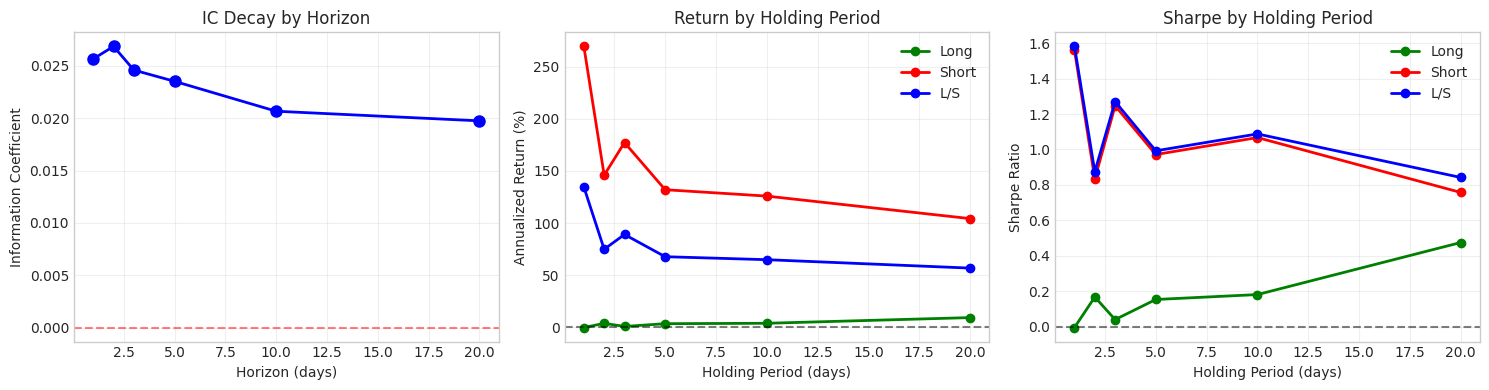

In [15]:
# Visualize horizon analysis
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

# IC decay
ax = axes[0]
ax.plot(ic_df['horizon'], ic_df['IC'], 'b-o', linewidth=2, markersize=8)
ax.axhline(0, color='red', linestyle='--', alpha=0.5)
ax.set_xlabel('Horizon (days)')
ax.set_ylabel('Information Coefficient')
ax.set_title('IC Decay by Horizon')
ax.grid(True, alpha=0.3)

# Annualized returns
ax = axes[1]
ax.plot(horizon_df['horizon'], horizon_df['long_ann'], 'g-o', label='Long', linewidth=2)
ax.plot(horizon_df['horizon'], horizon_df['short_ann'], 'r-o', label='Short', linewidth=2)
ax.plot(horizon_df['horizon'], horizon_df['ls_ann'], 'b-o', label='L/S', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Holding Period (days)')
ax.set_ylabel('Annualized Return (%)')
ax.set_title('Return by Holding Period')
ax.legend()
ax.grid(True, alpha=0.3)

# Sharpe ratio
ax = axes[2]
ax.plot(horizon_df['horizon'], horizon_df['long_sharpe'], 'g-o', label='Long', linewidth=2)
ax.plot(horizon_df['horizon'], horizon_df['short_sharpe'], 'r-o', label='Short', linewidth=2)
ax.plot(horizon_df['horizon'], horizon_df['ls_sharpe'], 'b-o', label='L/S', linewidth=2)
ax.axhline(0, color='black', linestyle='--', alpha=0.5)
ax.set_xlabel('Holding Period (days)')
ax.set_ylabel('Sharpe Ratio')
ax.set_title('Sharpe by Holding Period')
ax.legend()
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## 4. Combined Analysis: Liquid + Longer Horizon

In [16]:
# Test liquid stocks at different horizons
print("LIQUID STOCKS ($50M+) AT DIFFERENT HORIZONS")
print("=" * 80)

liquid_test = test_with_fwd[test_with_fwd['avg_dollar_volume'] >= 50e6].copy()
print(f"Liquid universe: {liquid_test['symbol'].nunique()} unique symbols")

liquid_horizon_perf = []

for h in horizons:
    col = f'fwd_{h}d'
    
    long_returns = []
    short_returns = []
    
    for date, group in liquid_test.groupby('feature_date'):
        valid = group.dropna(subset=[col])
        if len(valid) < 10:
            continue
        
        top_k = valid.nlargest(K, 'score')
        bottom_k = valid.nsmallest(K, 'score')
        
        long_returns.append(top_k[col].mean())
        short_returns.append(-bottom_k[col].mean())
    
    if len(long_returns) < 30:
        continue
    
    long_arr = np.array(long_returns)
    short_arr = np.array(short_returns)
    ls_arr = (long_arr + short_arr) / 2
    
    periods_per_year = 252 / h
    
    liquid_horizon_perf.append({
        'horizon': h,
        'long_ann': long_arr.mean() * periods_per_year * 100,
        'long_sharpe': long_arr.mean() / long_arr.std() * np.sqrt(periods_per_year),
        'short_ann': short_arr.mean() * periods_per_year * 100,
        'short_sharpe': short_arr.mean() / short_arr.std() * np.sqrt(periods_per_year),
        'ls_ann': ls_arr.mean() * periods_per_year * 100,
        'ls_sharpe': ls_arr.mean() / ls_arr.std() * np.sqrt(periods_per_year),
        'n_periods': len(long_returns),
    })

liquid_horizon_df = pd.DataFrame(liquid_horizon_perf)
print(liquid_horizon_df[['horizon', 'long_ann', 'long_sharpe', 'short_ann', 'short_sharpe', 'ls_ann', 'ls_sharpe', 'n_periods']].round(2).to_string(index=False))

LIQUID STOCKS ($50M+) AT DIFFERENT HORIZONS
Liquid universe: 995 unique symbols
 horizon  long_ann  long_sharpe  short_ann  short_sharpe  ls_ann  ls_sharpe  n_periods
       1    -11.84        -0.51    -168.22         -1.26  -90.03      -1.38        238
       2      2.75         0.12    -129.97         -1.29  -63.61      -1.31        237
       3      1.73         0.07    -110.88         -1.21  -54.58      -1.22        236
       5      1.74         0.07    -119.43         -1.24  -58.85      -1.23        234
      10      4.25         0.19     -74.88         -0.84  -35.31      -0.79        232
      20      7.60         0.38     -30.93         -0.43  -11.67      -0.34        228


## 5. Cost-Adjusted Analysis

What returns survive after realistic trading costs?

In [17]:
# Estimate realistic costs for liquid stocks
# Assumptions for >$50M daily volume:
# - Spread: 0.1% (10 bps)
# - Market impact: 0.05% (5 bps)
# - Borrow cost (shorts): 3% annual = 0.012% daily

SPREAD_COST = 0.001  # 10 bps round-trip
IMPACT_COST = 0.0005  # 5 bps each way
BORROW_COST_DAILY = 0.03 / 252  # 3% annual

print("COST-ADJUSTED RETURNS (Liquid Stocks)")
print("=" * 80)
print(f"Assumed costs: Spread={SPREAD_COST*100:.2f}%, Impact={IMPACT_COST*100*2:.2f}% RT, Borrow={BORROW_COST_DAILY*252*100:.1f}% ann")
print()

cost_adjusted = []

for h in horizons:
    # Per-period costs
    long_cost = (SPREAD_COST + IMPACT_COST * 2)  # Entry + exit
    short_cost = (SPREAD_COST + IMPACT_COST * 2) + (BORROW_COST_DAILY * h)  # + borrow
    
    # Get gross returns
    row = liquid_horizon_df[liquid_horizon_df['horizon'] == h]
    if len(row) == 0:
        continue
    row = row.iloc[0]
    
    periods_per_year = 252 / h
    
    # Gross per-period returns
    long_gross = row['long_ann'] / 100 / periods_per_year
    short_gross = row['short_ann'] / 100 / periods_per_year
    
    # Net returns
    long_net = long_gross - long_cost
    short_net = short_gross - short_cost
    ls_net = (long_net + short_net) / 2
    
    cost_adjusted.append({
        'horizon': h,
        'long_gross_ann': row['long_ann'],
        'long_cost_ann': long_cost * periods_per_year * 100,
        'long_net_ann': long_net * periods_per_year * 100,
        'short_gross_ann': row['short_ann'],
        'short_cost_ann': short_cost * periods_per_year * 100,
        'short_net_ann': short_net * periods_per_year * 100,
        'ls_net_ann': ls_net * periods_per_year * 100,
    })

cost_df = pd.DataFrame(cost_adjusted)
print(cost_df.round(1).to_string(index=False))

COST-ADJUSTED RETURNS (Liquid Stocks)
Assumed costs: Spread=0.10%, Impact=0.10% RT, Borrow=3.0% ann

 horizon  long_gross_ann  long_cost_ann  long_net_ann  short_gross_ann  short_cost_ann  short_net_ann  ls_net_ann
       1           -11.8           50.4         -62.2           -168.2            53.4         -221.6      -141.9
       2             2.8           25.2         -22.4           -130.0            28.2         -158.2       -90.3
       3             1.7           16.8         -15.1           -110.9            19.8         -130.7       -72.9
       5             1.7           10.1          -8.3           -119.4            13.1         -132.5       -70.4
      10             4.3            5.0          -0.8            -74.9             8.0          -82.9       -41.9
      20             7.6            2.5           5.1            -30.9             5.5          -36.4       -15.7


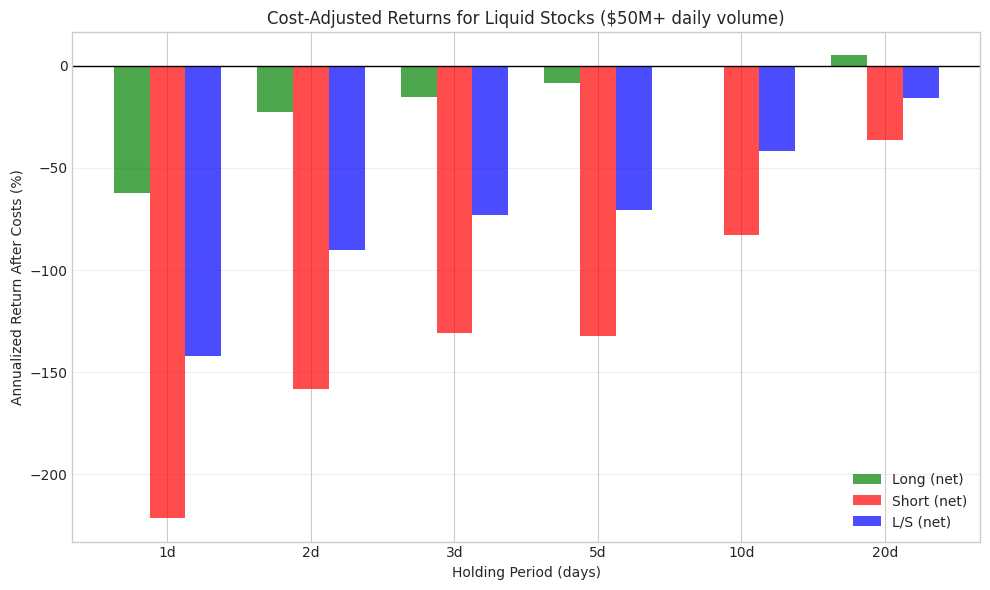

In [18]:
# Visualize cost-adjusted returns
fig, ax = plt.subplots(figsize=(10, 6))

x = np.arange(len(cost_df))
width = 0.25

bars1 = ax.bar(x - width, cost_df['long_net_ann'], width, label='Long (net)', color='green', alpha=0.7)
bars2 = ax.bar(x, cost_df['short_net_ann'], width, label='Short (net)', color='red', alpha=0.7)
bars3 = ax.bar(x + width, cost_df['ls_net_ann'], width, label='L/S (net)', color='blue', alpha=0.7)

ax.axhline(0, color='black', linestyle='-', linewidth=1)
ax.set_xlabel('Holding Period (days)')
ax.set_ylabel('Annualized Return After Costs (%)')
ax.set_title('Cost-Adjusted Returns for Liquid Stocks ($50M+ daily volume)')
ax.set_xticks(x)
ax.set_xticklabels([f"{h}d" for h in cost_df['horizon']])
ax.legend()
ax.grid(axis='y', alpha=0.3)

plt.tight_layout()
plt.show()

## 6. Summary & Recommendations

In [19]:
print("=" * 70)
print("STRATEGY RETHINK SUMMARY")
print("=" * 70)

print("""
QUESTION 1: Does the long side work?
------------------------------------""")
print(f"All stocks - Long top-5: {results_df['long_return'].mean()*252*100:.1f}% ann, Sharpe {results_df['long_return'].mean()/results_df['long_return'].std()*np.sqrt(252):.2f}")
print(f"All stocks - Short bottom-5: {results_df['short_return'].mean()*252*100:.1f}% ann, Sharpe {results_df['short_return'].mean()/results_df['short_return'].std()*np.sqrt(252):.2f}")

print("""
QUESTION 2: Is there signal in liquid stocks?
---------------------------------------------""")
if len(thresh_df) > 0:
    for _, row in thresh_df.iterrows():
        print(f"${row['threshold']:.0f}M+: Long {row['long_daily']*252*100:.1f}% ann, Short {row['short_daily']*252*100:.1f}% ann")

print("""
QUESTION 3: Do longer holding periods help?
-------------------------------------------""")
if len(horizon_df) > 0:
    for _, row in horizon_df.iterrows():
        print(f"{row['horizon']:2.0f}d hold: Long {row['long_ann']:.1f}% ann (Sharpe {row['long_sharpe']:.2f}), Short {row['short_ann']:.1f}% ann (Sharpe {row['short_sharpe']:.2f})")

print("""
QUESTION 4: What survives after costs?
--------------------------------------""")
if len(cost_df) > 0:
    best_long = cost_df.loc[cost_df['long_net_ann'].idxmax()]
    best_short = cost_df.loc[cost_df['short_net_ann'].idxmax()]
    best_ls = cost_df.loc[cost_df['ls_net_ann'].idxmax()]
    
    print(f"Best long: {best_long['horizon']:.0f}d hold → {best_long['long_net_ann']:.1f}% net ann")
    print(f"Best short: {best_short['horizon']:.0f}d hold → {best_short['short_net_ann']:.1f}% net ann")
    print(f"Best L/S: {best_ls['horizon']:.0f}d hold → {best_ls['ls_net_ann']:.1f}% net ann")

STRATEGY RETHINK SUMMARY

QUESTION 1: Does the long side work?
------------------------------------
All stocks - Long top-5: 1.7% ann, Sharpe 0.07
All stocks - Short bottom-5: 231.0% ann, Sharpe 1.32

QUESTION 2: Is there signal in liquid stocks?
---------------------------------------------
$10M+: Long 8.4% ann, Short -41.1% ann
$25M+: Long 0.4% ann, Short -256.1% ann
$50M+: Long -8.4% ann, Short -168.1% ann
$100M+: Long -7.6% ann, Short -215.1% ann
$200M+: Long -4.9% ann, Short -169.7% ann

QUESTION 3: Do longer holding periods help?
-------------------------------------------
 1d hold: Long -0.1% ann (Sharpe -0.00), Short 269.3% ann (Sharpe 1.56)
 2d hold: Long 3.9% ann (Sharpe 0.17), Short 145.9% ann (Sharpe 0.83)
 3d hold: Long 1.0% ann (Sharpe 0.04), Short 177.1% ann (Sharpe 1.25)
 5d hold: Long 3.6% ann (Sharpe 0.15), Short 132.0% ann (Sharpe 0.97)
10d hold: Long 4.0% ann (Sharpe 0.18), Short 125.8% ann (Sharpe 1.07)
20d hold: Long 9.4% ann (Sharpe 0.48), Short 104.3% ann (Sharp

In [20]:
# Final recommendation
print("\n" + "=" * 70)
print("RECOMMENDATION")
print("=" * 70)

# Find best viable strategy
viable_strategies = []

for _, row in cost_df.iterrows():
    if row['long_net_ann'] > 10:  # >10% net annual seems viable
        viable_strategies.append(f"Long {row['horizon']:.0f}d: {row['long_net_ann']:.1f}% net")
    if row['short_net_ann'] > 10:
        viable_strategies.append(f"Short {row['horizon']:.0f}d: {row['short_net_ann']:.1f}% net")
    if row['ls_net_ann'] > 10:
        viable_strategies.append(f"L/S {row['horizon']:.0f}d: {row['ls_net_ann']:.1f}% net")

if viable_strategies:
    print("\nPotentially viable strategies (>10% net annual):")
    for s in viable_strategies:
        print(f"  - {s}")
else:
    print("\nNo strategies exceed 10% net annual return.")
    print("Consider:")
    print("  - Retraining model specifically on liquid stocks")
    print("  - Adding other factors (momentum, value)")
    print("  - Using news as a filter rather than primary signal")
    print("  - Aggregating to sector level for ETF trading")


RECOMMENDATION

No strategies exceed 10% net annual return.
Consider:
  - Retraining model specifically on liquid stocks
  - Adding other factors (momentum, value)
  - Using news as a filter rather than primary signal
  - Aggregating to sector level for ETF trading
